# Paddy Dataset: Processing & Exploration (Step-by-Step)


## 1) Install dependencies (Colab only)
Skip if already installed.

In [ ]:
!pip -q install pandas numpy matplotlib scikit-learn


## 2) Upload dataset to Colab

In [ ]:
from google.colab import files
_=files.upload()


Saving paddydataset.csv to paddydataset.csv


## 3) Imports and configuration

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit, LeaveOneGroupOut
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

DATA_PATH = Path('paddydataset.csv')
OUT_DIR = None  # no file outputs in notebook
TARGET_COL = 'Paddy yield(in Kg)'

def clean_columns(cols):
    return [c.strip().replace('  ', ' ') for c in cols]

## 4) Load data and basic info

In [ ]:
df = pd.read_csv(DATA_PATH)
df.columns = clean_columns(list(df.columns))
print('Shape:', df.shape, '\n')
print('Columns:', df.columns.tolist(), '\n')
print('Dtypes:\n', df.dtypes, '\n')
print('Missing values (top 10):\n', df.isna().sum().sort_values(ascending=False).head(10))
print('\nTarget summary:\n', df[TARGET_COL].describe())

Shape: (2789, 45) 

Columns: ['Hectares', 'Agriblock', 'Variety', 'Soil Types', 'Seedrate(in Kg)', 'LP_Mainfield(in Tonnes)', 'Nursery', 'Nursery area (Cents)', 'LP_nurseryarea(in Tonnes)', 'DAP_20days', 'Weed28D_thiobencarb', 'Urea_40Days', 'Potassh_50Days', 'Micronutrients_70Days', 'Pest_60Day(in ml)', '30DRain( in mm)', '30DAI(in mm)', '30_50DRain( in mm)', '30_50DAI(in mm)', '51_70DRain(in mm)', '51_70AI(in mm)', '71_105DRain(in mm)', '71_105DAI(in mm)', 'Min temp_D1_D30', 'Max temp_D1_D30', 'Min temp_D31_D60', 'Max temp_D31_D60', 'Min temp_D61_D90', 'Max temp_D61_D90', 'Min temp_D91_D120', 'Max temp_D91_D120', 'Inst Wind Speed_D1_D30(in Knots)', 'Inst Wind Speed_D31_D60(in Knots)', 'Inst Wind Speed_D61_D90(in Knots)', 'Inst Wind Speed_D91_D120(in Knots)', 'Wind Direction_D1_D30', 'Wind Direction_D31_D60', 'Wind Direction_D61_D90', 'Wind Direction_D91_D120', 'Relative Humidity_D1_D30', 'Relative Humidity_D31_D60', 'Relative Humidity_D61_D90', 'Relative Humidity_D91_D120', 'Trash(in

## 5) Duplicate check (raw data)

In [ ]:
dup_count = df.duplicated().sum()
print('Duplicate rows (before dedup):', dup_count)
if dup_count > 0:
    print('Example duplicate rows (first 5):')
    print(df[df.duplicated(keep=False)].head(5))


Duplicate rows (before dedup): 451
Example duplicate rows (first 5):
    Hectares     Agriblock      Variety Soil Types  Seedrate(in Kg)  \
54         6     Cuddalore        CO_43       clay              150   
60         6     Cuddalore        CO_43       clay              150   
70         6  Sankarapuram      ponmani   alluvial              150   
76         6  Sankarapuram  delux ponni   alluvial              150   
80         6       Panruti  delux ponni       clay              150   

    LP_Mainfield(in Tonnes) Nursery  Nursery area (Cents)  \
54                     75.0     wet                   120   
60                     75.0     dry                   120   
70                     75.0     dry                   120   
76                     75.0     dry                   120   
80                     75.0     wet                   120   

    LP_nurseryarea(in Tonnes)  DAP_20days  ...  Wind Direction_D1_D30  \
54                          6         240  ...                  

## 6) Deduplicate

In [ ]:
before_rows = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after_rows = len(df)
print(f'Deduplication: {before_rows} -> {after_rows} rows (removed {before_rows - after_rows})')


Deduplication: 2789 -> 2338 rows (removed 451)


In [ ]:
RAW_TARGET_COL = "Paddy yield(in Kg)"
TARGET_COL = "Paddy yield_per_hectare(in Kg)"
size_col = "Hectares"
perfect_size_cols = [
    "LP_nurseryarea(in Tonnes)",
    "Micronutrients_70Days",
    "Weed28D_thiobencarb",
    "Urea_40Days",
    "DAP_20days",
    "Nursery area (Cents)",
    "Pest_60Day(in ml)",
    "LP_Mainfield(in Tonnes)",
    "Seedrate(in Kg)",
    "Potassh_50Days",
    "Trash(in bundles)",
]

if size_col not in df.columns:
    raise ValueError(f"Size column not found for normalization: {size_col}")

hectares = pd.to_numeric(df[size_col], errors="coerce")
df[TARGET_COL] = pd.to_numeric(df[RAW_TARGET_COL], errors="coerce") / hectares

for col in perfect_size_cols:
    if col in df.columns:
        per_col = f"{col}_per_hectare"
        df[per_col] = pd.to_numeric(df[col], errors="coerce") / hectares
        df = df.drop(columns=[col])


## 7) Correlations and plots

Top correlations with target:
 Paddy yield_per_hectare(in Kg)       1.000000
Paddy yield(in Kg)                   0.672584
Hectares                             0.594878
Urea_40Days_per_hectare              0.165088
Inst Wind Speed_D1_D30(in Knots)     0.030733
Inst Wind Speed_D61_D90(in Knots)    0.027924
Max temp_D61_D90                     0.027327
30DAI(in mm)                         0.020557
Name: Paddy yield_per_hectare(in Kg), dtype: float64 

Bottom correlations with target:
 LP_nurseryarea(in Tonnes)_per_hectare   NaN
Micronutrients_70Days_per_hectare       NaN
Weed28D_thiobencarb_per_hectare         NaN
DAP_20days_per_hectare                  NaN
Nursery area (Cents)_per_hectare        NaN
Pest_60Day(in ml)_per_hectare           NaN
LP_Mainfield(in Tonnes)_per_hectare     NaN
Seedrate(in Kg)_per_hectare             NaN
Name: Paddy yield_per_hectare(in Kg), dtype: float64 



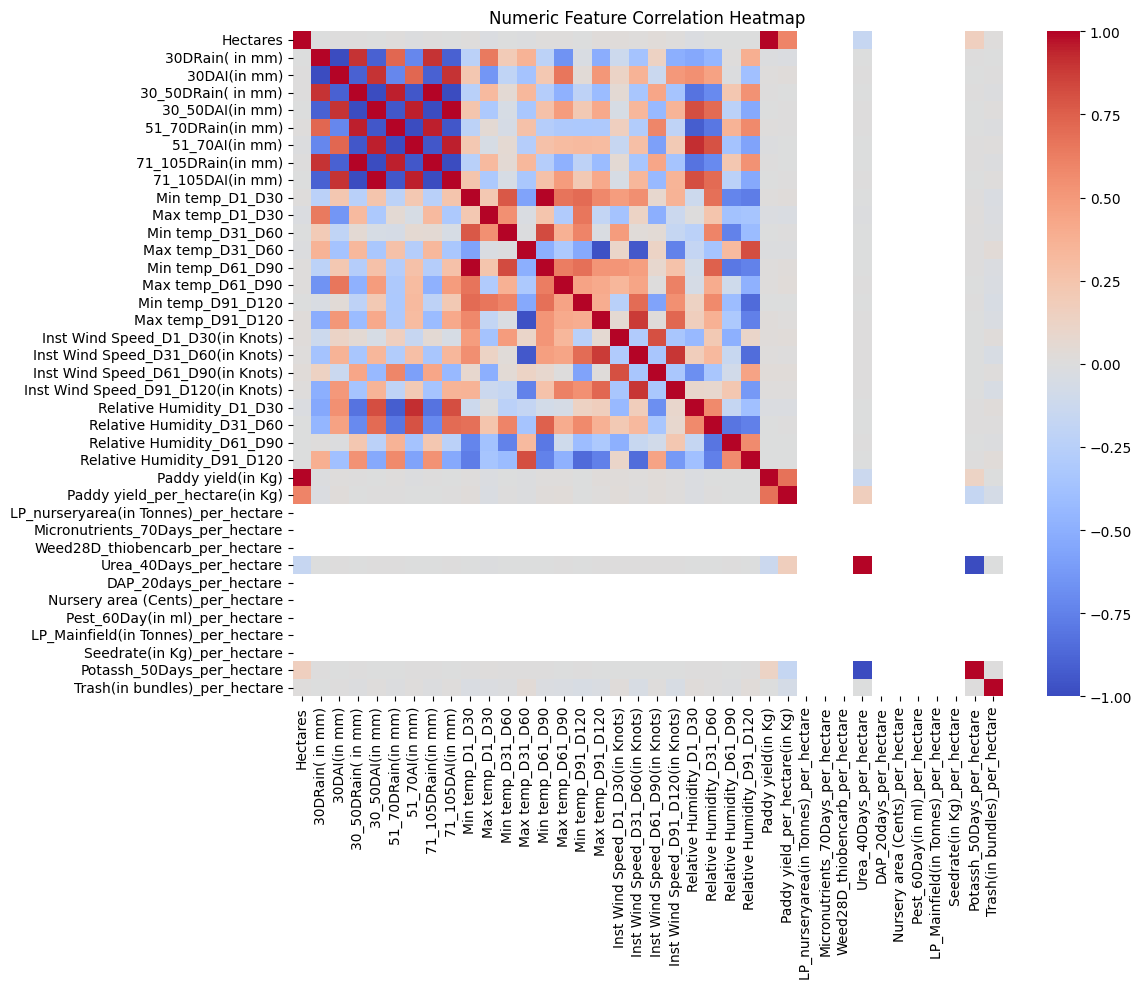

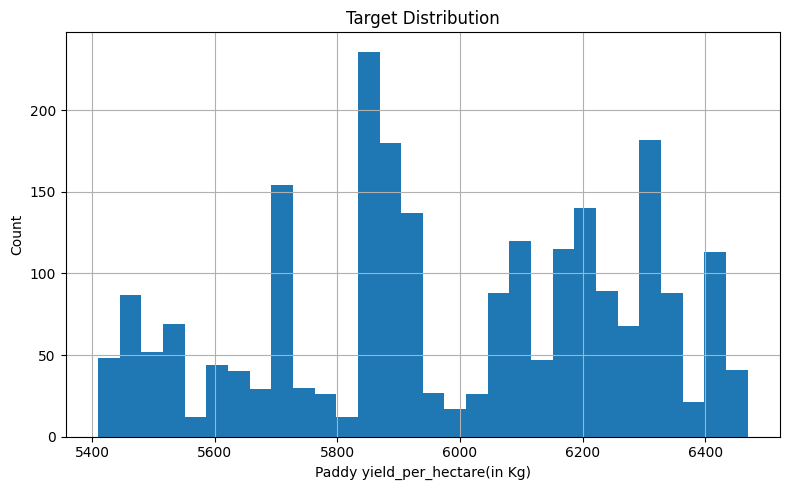

In [ ]:
num_df = df.select_dtypes(include=[np.number])
high_corr_cols = []
if not num_df.empty:
    corr_matrix = num_df.corr(numeric_only=True)
    corr_target = corr_matrix[TARGET_COL].sort_values(ascending=False)
    print('Top correlations with target:\n', corr_target.head(8), '\n')
    print('Bottom correlations with target:\n', corr_target.tail(8), '\n')
    high_corr_cols = [c for c, v in corr_target.items() if c != TARGET_COL and abs(v) >= 0.98]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, cbar=True)
    plt.title('Numeric Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8, 5))
df[TARGET_COL].hist(bins=30)
plt.title('Target Distribution')
plt.xlabel(TARGET_COL)
plt.ylabel('Count')
plt.tight_layout()
plt.show()